In [2]:
from __future__ import print_function

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from __future__ import division
pd.set_option('display.width',5000)

In [4]:
#load the bank_kaggle data
df = pd.read_csv('bank_full_1.csv')

In [5]:
#check the shape of the data
df.shape

(45211, 17)

In [6]:
df.head(3)

age           job  marital  education default  balance housing loan  contact  day month  duration  campaign  pdays  previous poutcome   y
0   58    management  married   tertiary      no     2143     yes   no  unknown    5   may       261         1     -1         0  unknown  no
1   44    technician   single  secondary      no       29     yes   no  unknown    5   may       151         1     -1         0  unknown  no
2   33  entrepreneur  married  secondary      no        2     yes  yes  unknown    5   may        76         1     -1         0  unknown  no

In [73]:
#information about the data
# Input variables:
#    # bank client data:
#    1 - age (numeric)
#    2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
#                                        "blue-collar","self-employed","retired","technician","services") 
#    3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
#    4 - education (categorical: "unknown","secondary","primary","tertiary")
#    5 - default: has credit in default? (binary: "yes","no")
#    6 - balance: average yearly balance, in euros (numeric) 
#    7 - housing: has housing loan? (binary: "yes","no")
#    8 - loan: has personal loan? (binary: "yes","no")
#    # related with the last contact of the current campaign:
#    9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
#   10 - day: last contact day of the month (numeric)
#   11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
#   12 - duration: last contact duration, in seconds (numeric)
#    # other attributes:
#   13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
#   14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
#   15 - previous: number of contacts performed before this campaign and for this client (numeric)
#   16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

#   Output variable (desired target):
#   17 - y - has the client subscribed a term deposit? (binary: "yes","no")

# 8. Missing Attribute Values: None

EDA focus on: 1. Whether a feature is leaky. We don't want to include data that's only available in the feature.
2. How well the data differentiate under the feature. 
3. Whether it overlaps with other features.

In [10]:
df.pdays.value_counts()

-1      36954
 182      167
 92       147
 183      126
 91       126
 181      117
 370       99
 184       85
 364       77
 95        74
 350       73
 94        72
 175       71
 185       68
 93        65
 343       65
 188       64
 189       60
 186       60
 174       57
 96        57
 349       57
 363       55
 97        54
 90        54
 196       51
 365       51
 368       49
 342       49
 98        49
        ...  
 774        1
 550        1
 396        1
 492        1
 466        1
 45         1
 434        1
 18         1
 529        1
 465        1
 401        1
 784        1
 656        1
 592        1
 528        1
 464        1
 432        1
 655        1
 495        1
 543        1
 47         1
 782        1
 686        1
 558        1
 526        1
 749        1
 717        1
 589        1
 493        1
 32         1
Name: pdays, Length: 559, dtype: int64

Most of the the pdays has value -1, means the person hasn't been contacted before. We could potentially bin the data into two groups, -1 and not -1, but that overlaps with previous contact number. Overall, pdays is not a useful feature to keep.

In [13]:
df.age.describe()

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

Average age is 41, and the youngest is 18 and oldest is 95. Bining the age help to simiplify the model. 
Bins were created with 10 as smallest, 100 as biggest and 10 as interval. For example, bins 10-19 will be labeled as 10, 
if a person is 18, the bin is 10.

In [15]:
bins = np.arange(10,110,10)
labels = np.arange(10,110,10)[:len(bins)-1]
df['binned_age'] = pd.cut(df['age'], bins=bins, labels=labels)

df_age = pd.crosstab(df.binned_age, df.y, margins=True)
df_age.reset_index(inplace = True)
df_age['percentage'] = df_age.yes/df_age.All*100

df_age = df_age.iloc[:9,:]
df_age.sort_values(by ='binned_age', inplace = True)
df_age

y binned_age     no   yes    All  percentage
5         10    417   284    701   40.513552
3         20  10220  1019  11239    9.066643
2         30  15875  1812  17687   10.244813
1         40   5821  1112   6933   16.039233
0         50     64    33     97   34.020619
4         60   7256   811   8067   10.053304
7         70     54    38     92   41.304348
6         80    213   175    388   45.103093
8         90      2     5      7   71.428571

In [16]:
df.head(2)

age         job  marital  education default  balance housing loan  contact  day month  duration  campaign  pdays  previous poutcome   y binned_age
0   58  management  married   tertiary      no     2143     yes   no  unknown    5   may       261         1     -1         0  unknown  no         50
1   44  technician   single  secondary      no       29     yes   no  unknown    5   may       151         1     -1         0  unknown  no         40

In [17]:
age_percentage_plot = plt.bar(df_age.binned_age, df_age.percentage)
#the yes rate vary quite a lot between different age grou

In [77]:
#create a stack bar to show the number of each age group and the number os yes in each age group
sns.set_context({"figure.figsize": (24, 10)})

sns.barplot(x = df_age['binned_age'], 
            y = df_age.All, color = "red")

age_plot = sns.barplot(x = df_age['binned_age'], 
            y = df_age.yes, color = "blue")

for item in ([age_plot.xaxis.label, age_plot.yaxis.label] +
             age_plot.get_xticklabels() + age_plot.get_yticklabels()):
    item.set_fontsize(20)


The majority of the people is in 30-40 age group, with 20-30 as second. 

In [18]:
#investigate the percentage of yes in each job catergory
df_job = pd.crosstab(df.job, df.y, margins=True)
df_job.reset_index(inplace = True)
df_job['percentage'] = df_job.yes/df_job.All*100
df_job

y             job     no   yes    All  percentage
0          admin.   4540   631   5171   12.202669
1     blue-collar   9024   708   9732    7.274969
2    entrepreneur   1364   123   1487    8.271688
3       housemaid   1131   109   1240    8.790323
4      management   8157  1301   9458   13.755551
5         retired   1748   516   2264   22.791519
6   self-employed   1392   187   1579   11.842939
7        services   3785   369   4154    8.883004
8         student    669   269    938   28.678038
9      technician   6757   840   7597   11.056996
10     unemployed   1101   202   1303   15.502686
11        unknown    254    34    288   11.805556
12            All  39922  5289  45211   11.698480

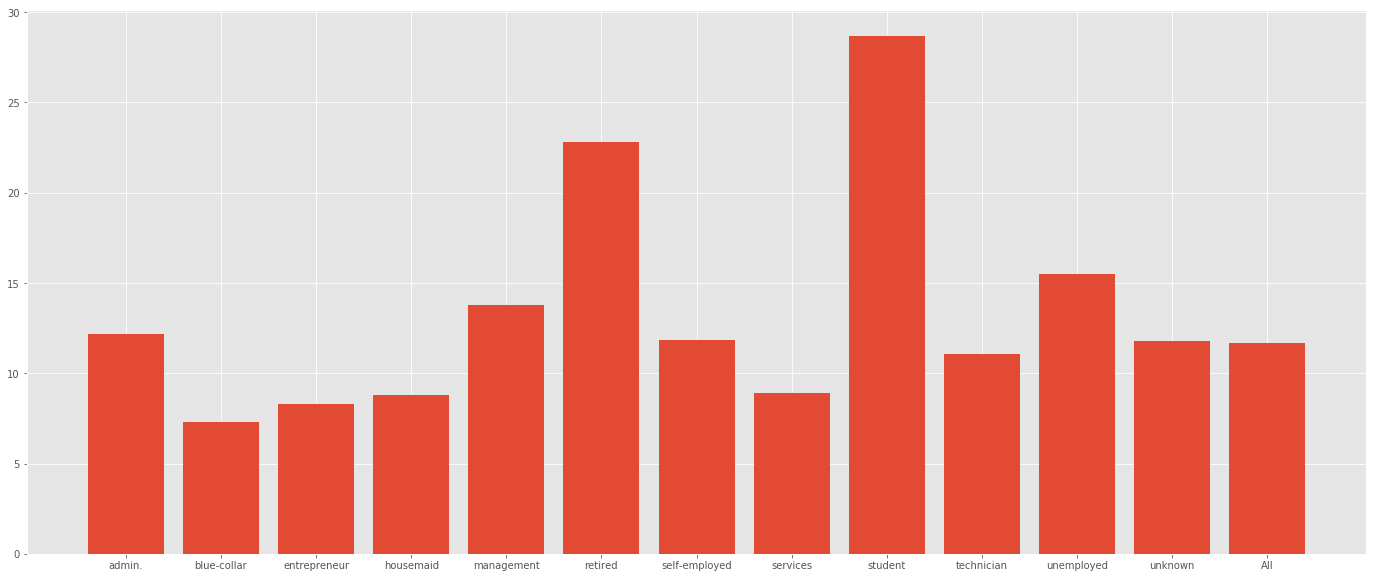

In [80]:
job_percentage_plot = plt.bar(df_job.job, df_job.percentage)

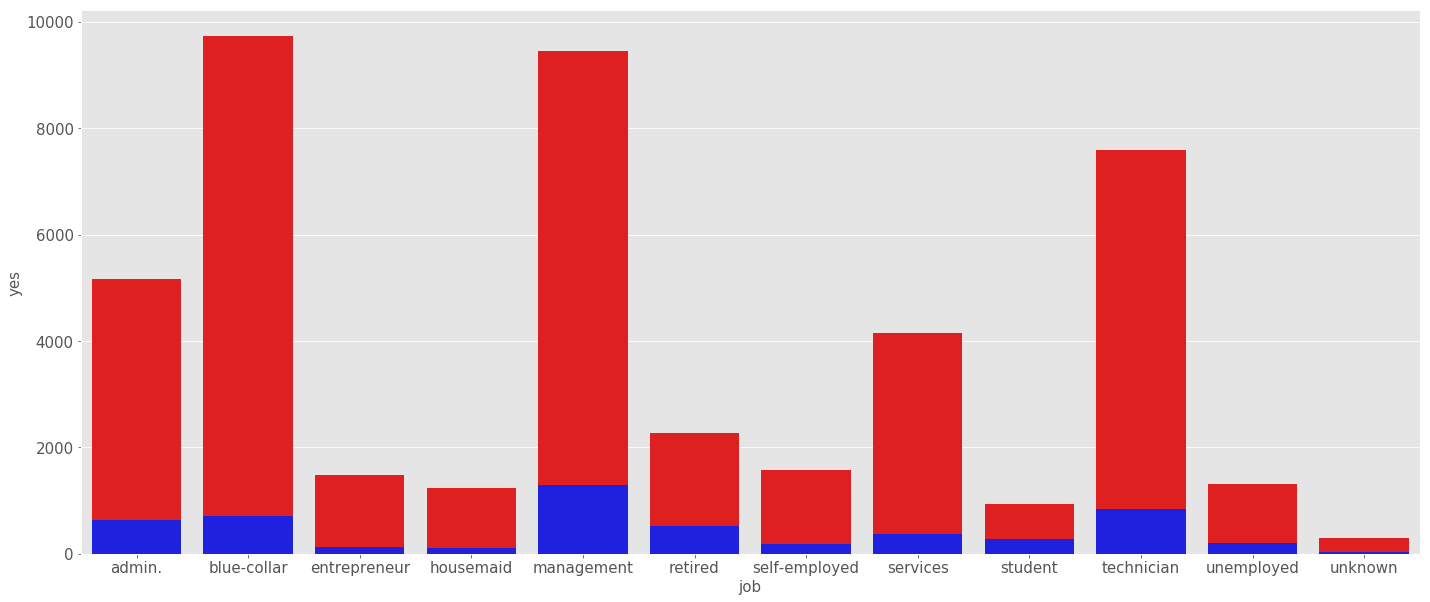

In [20]:
sns.set_context({"figure.figsize": (24, 10)})

sns.barplot(x = df_job['job'][:12], 
            y = df_job.All, color = "red")

job_plot = sns.barplot(x = df_job['job'][:12], 
            y = df_job.yes, color = "blue")

for item in ([job_plot.xaxis.label, job_plot.yaxis.label] +
             job_plot.get_xticklabels() + job_plot.get_yticklabels()):
    item.set_fontsize(15)
    
#yes rate vary quite a lot between different types of jobs, so job is an important feature

The percentage of yes varies quite a lot between different groups, 'retired' and 'student' stands out. But relatively there 
are not that many people come from those groups. Admin and management have very similar percentages, could potentially
combine. 

In [21]:
#investigate the percentage of yes in each marital catergory
df_marital = pd.crosstab(df.marital, df.y, margins=True)
df_marital.reset_index(inplace = True)
df_marital['percentage'] = df_marital.yes/df_marital.All*100
df_marital

y   marital     no   yes    All  percentage
0  divorced   4585   622   5207   11.945458
1   married  24459  2755  27214   10.123466
2    single  10878  1912  12790   14.949179
3       All  39922  5289  45211   11.698480

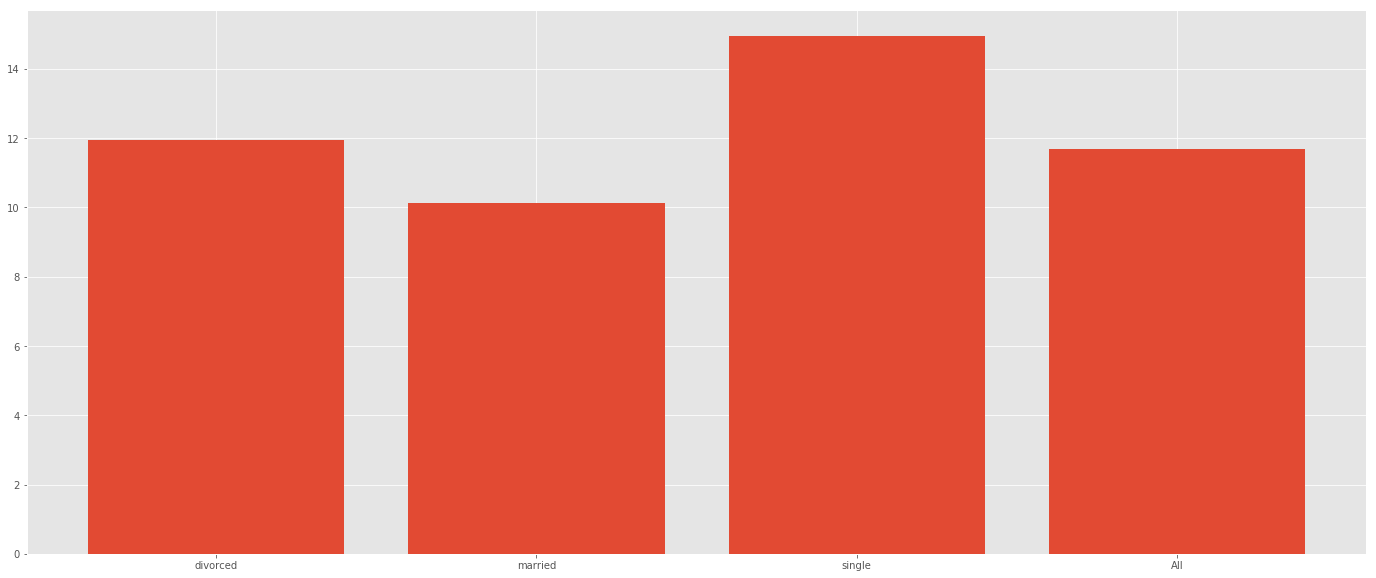

In [22]:
marital_percentage_plot = plt.bar(df_marital.marital, df_marital.percentage)

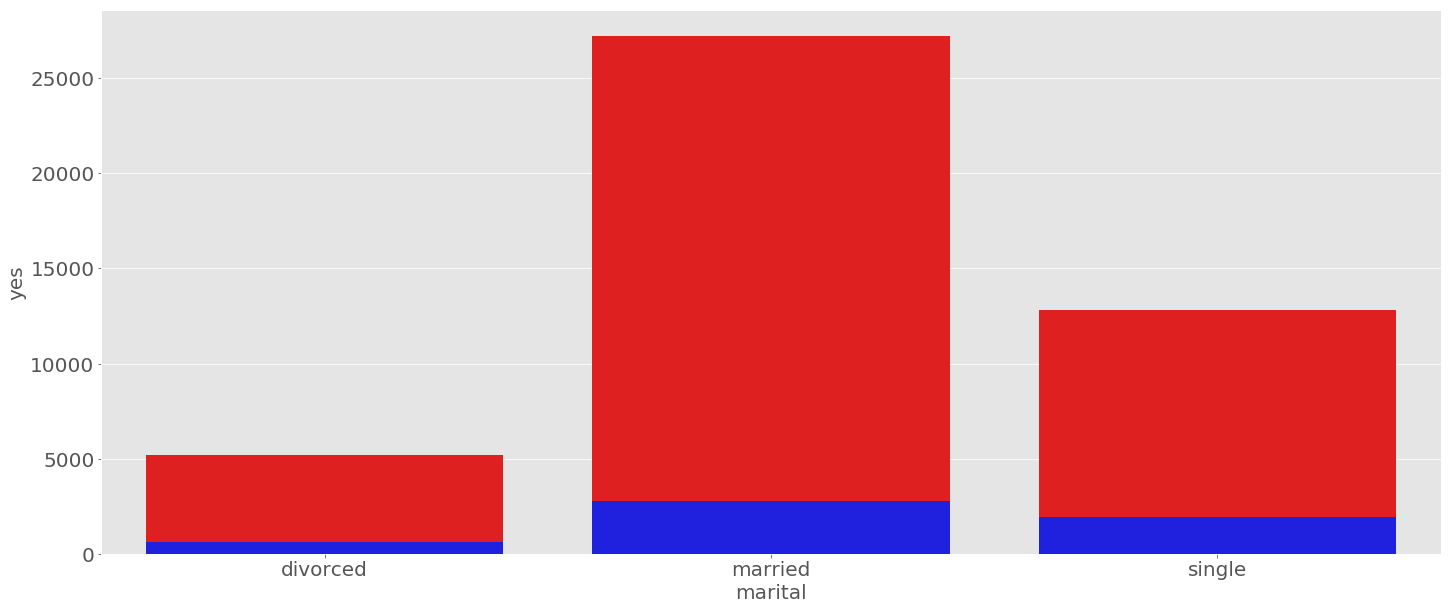

In [23]:
marital_percentage_plot = plt.bar(df_marital.marital, df_marital.percentage)
sns.set_context({"figure.figsize": (24, 10)})

sns.barplot(x = df_marital['marital'][:3], 
            y = df_marital.All, color = "red")

marital_plot = sns.barplot(x = df_marital['marital'][:3], 
            y = df_marital.yes, color = "blue")

for item in ([marital_plot.xaxis.label, marital_plot.yaxis.label] +
             marital_plot.get_xticklabels() + marital_plot.get_yticklabels()):
    item.set_fontsize(20)

#marital status did not vary much between conditions, maybe able to get rid of it

The percentage is not very different among the different maritial group. The majority of the people is married.

In [24]:
#investigate the percentage of yes in each job catergory
df_education = pd.crosstab(df.education, df.y, margins=True)
df_education.reset_index(inplace = True)
df_education['percentage'] = df_education.yes/df_education.All*100
df_education

y  education     no   yes    All  percentage
0    primary   6260   591   6851    8.626478
1  secondary  20752  2450  23202   10.559435
2   tertiary  11305  1996  13301   15.006390
3    unknown   1605   252   1857   13.570275
4        All  39922  5289  45211   11.698480

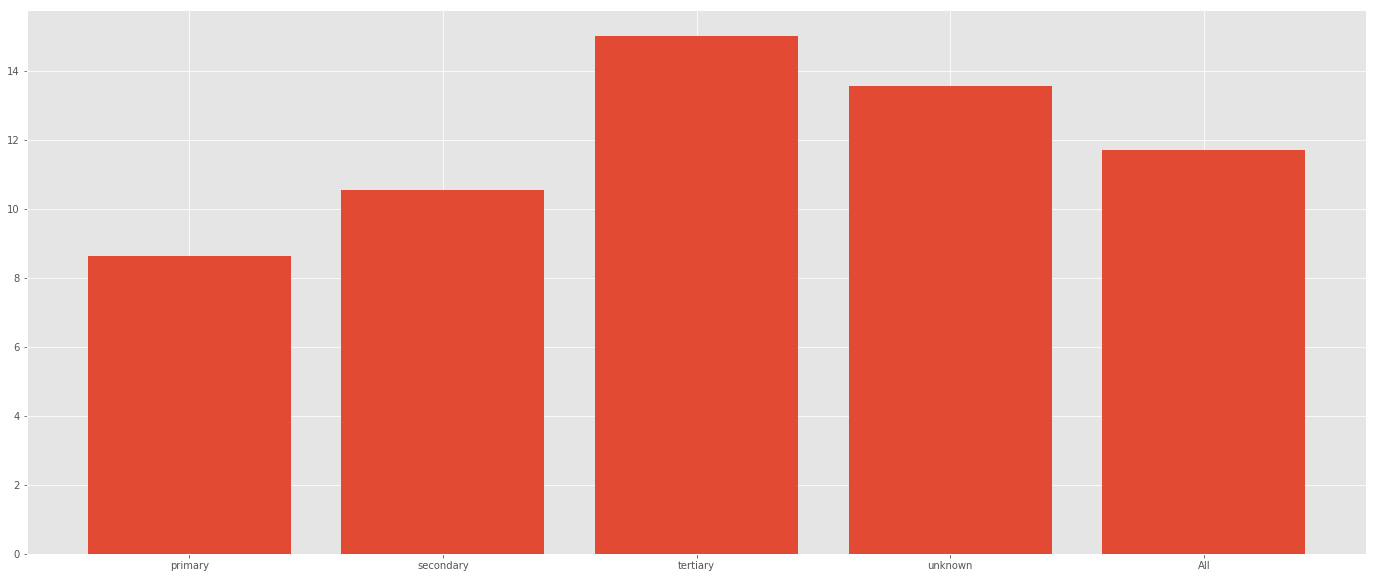

In [25]:
education_percentage_plot = plt.bar(df_education.education, df_education.percentage)

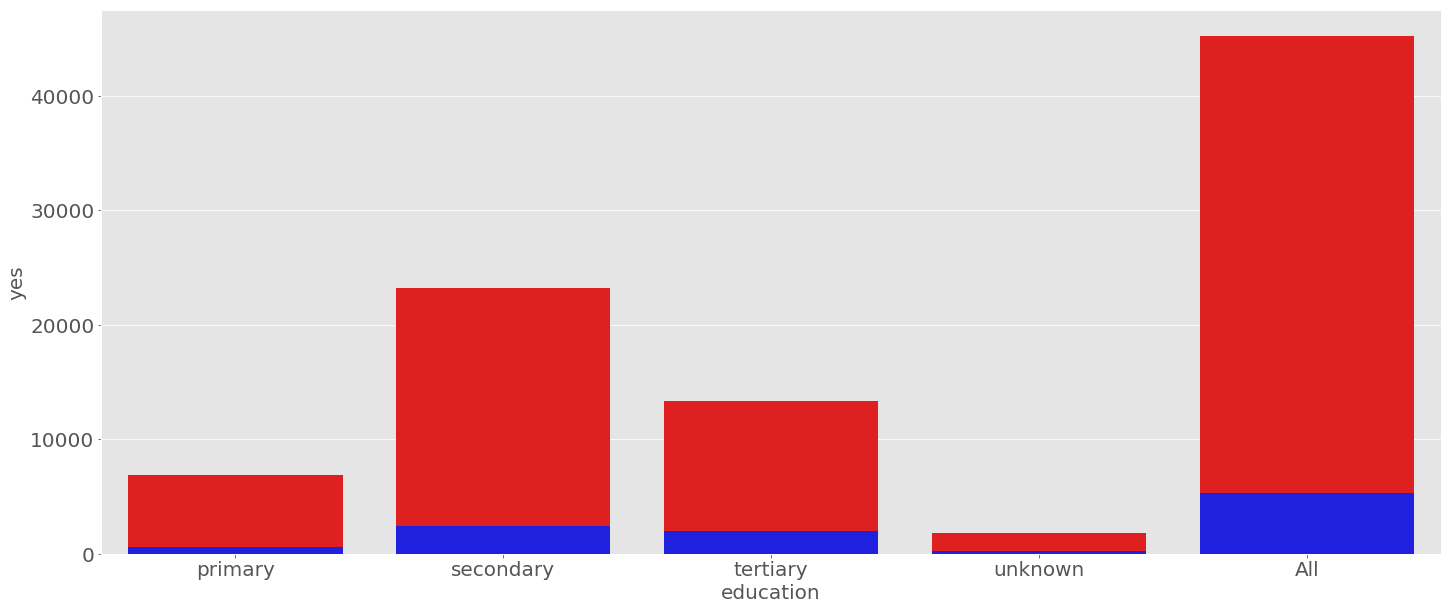

In [26]:
sns.set_context({"figure.figsize": (24, 10)})

sns.barplot(x = df_education['education'], 
            y = df_education.All, color = "red")

education_plot = sns.barplot(x = df_education['education'], 
            y = df_education.yes, color = "blue")

for item in ([education_plot.xaxis.label, education_plot.yaxis.label] +
             education_plot.get_xticklabels() + education_plot.get_yticklabels()):
    item.set_fontsize(20)

#the higher education, the higher percentage of yes

In [88]:
#investigate the percentage of yes in each default catergory
df_default = pd.crosstab(df.default, df.y, margins=True)
df_default.reset_index(inplace = True)
df_default['percentage'] = df_default.yes/df_default.All*100
df_default

y default     no   yes    All  percentage
0      no  39159  5237  44396   11.796108
1     yes    763    52    815    6.380368
2     All  39922  5289  45211   11.698480

In [32]:
df.groupby('default').count()

age    job  marital  education  balance  housing   loan  contact    day  month  duration  campaign  pdays  previous  poutcome      y  binned_age  binned_balance
default                                                                                                                                                                    
no       44396  44396    44396      44396    44396    44396  44396    44396  44396  44396     44396     44396  44396     44396     44396  44396       44396           44396
yes        815    815      815        815      815      815    815      815    815    815       815       815    815       815       815    815         815             815

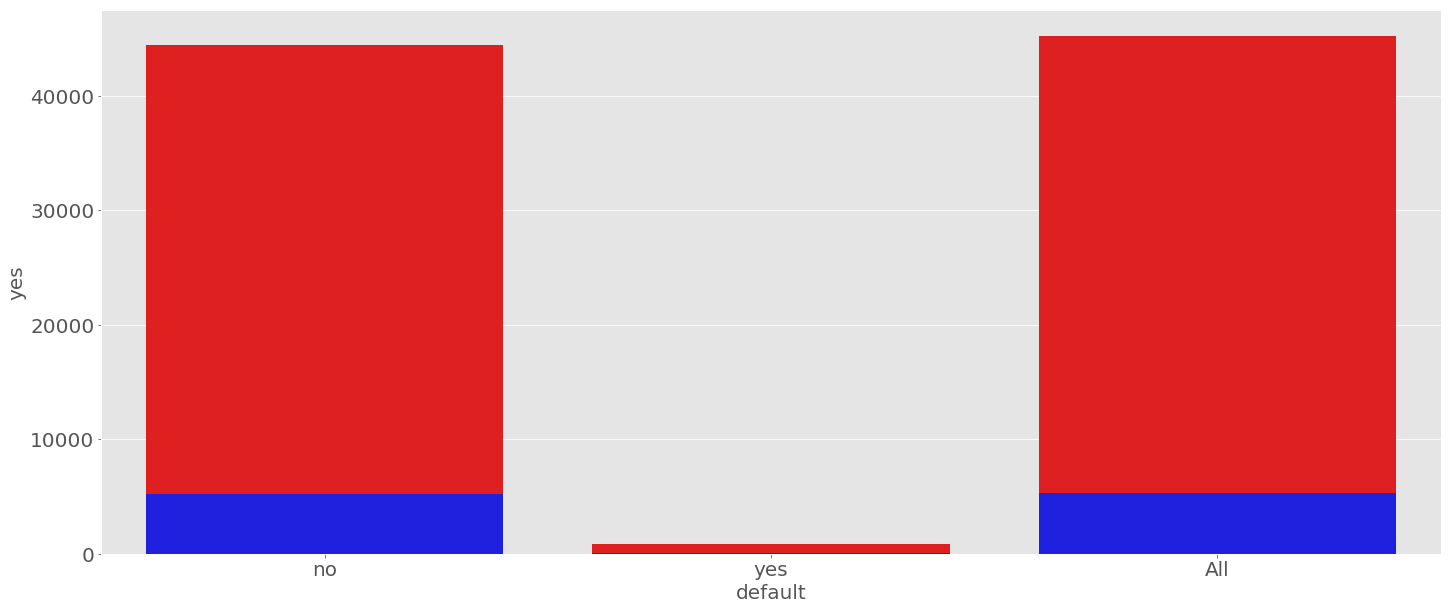

In [89]:
sns.set_context({"figure.figsize": (24, 10)})

sns.barplot(x = df_default['default'], 
            y = df_default.All, color = "red")

default_plot = sns.barplot(x = df_default['default'], 
            y = df_default.yes, color = "blue")

for item in ([default_plot.xaxis.label, default_plot.yaxis.label] +
             default_plot.get_xticklabels() + default_plot.get_yticklabels()):
    item.set_fontsize(20)

#Though majority of the people is in default no group, it is still valuable to keep this feature since the difference
#between the yes and no group is big.

In [74]:
#check how balance correlate with target
df.balance.describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [135]:
balance_bin = np.arange(-10000,150000,5000)
#print ('balance_bin',balance_bin)
balance_label = balance_bin[:len(balance_bin)-1]
#print ('balance_label',balance_label)
df['binned_balance'] = pd.cut(df['balance'], bins=balance_bin, labels=balance_label)

#df.groupby('binned_balance').count()
df_balance = pd.crosstab(df.binned_balance, df.y, margins=True)
df_balance
df_pivot_table = pd.pivot_table(df, index=df.binned_balance, columns=df.y, aggfunc='count')
df_pivot_table
# df_balance.reset_index(inplace = True)
# df_balance['percentage'] = df_balance.yes/df_balance.All*100
# df_balance = df_balance.iloc[:20,:]
# df_balance.sort_values(by ='binned_balance', inplace = True)
# df_balance

# df_default = pd.crosstab(df.default, df.y, margins=True)
# df_default.reset_index(inplace = True)
# df_default['percentage'] = df_default.yes/df_default.All*100
# df.head(10)

df.to_csv(path_or_buf='df.csv')

#crosstab counting result does not match groupby result, fix it later

In [122]:
df['add_100000'] = df['balance'] + 100000

In [123]:
df.head()

age           job  marital  education default  balance housing loan  contact  day    ...     pdays  previous  poutcome   y  binned_age binned_balance binned_campaign binned_previous binned_balance_2 add_100000
0   58    management  married   tertiary      no     2143     yes   no  unknown    5    ...        -1         0   unknown  no          50              0               0              -5               a0     102143
1   44    technician   single  secondary      no       29     yes   no  unknown    5    ...        -1         0   unknown  no          40              0               0              -5               a0     100029
2   33  entrepreneur  married  secondary      no        2     yes  yes  unknown    5    ...        -1         0   unknown  no          30              0               0              -5               a0     100002
3   47   blue-collar  married    unknown      no     1506     yes   no  unknown    5    ...        -1         0   unknown  no          40              0               0              -5               a0     101506
4   33       unknown   single    unknown      no        1      no   no  unknown    5    ...        -1         0   unknown  no          30              0               0              -5               a0     100001

[5 rows x 23 columns]

In [130]:
print(len(balance_label))
balance_label_2 = np.asarray(['a-10', 'a-5', 'a0', 'a5', 'a10', 'a15', 'a20', 'a25', 'a30', 'a35', 'a40', 'a45',
                  'a50', 'a55', 'a60', 'a65', 'a70', 'a75', 'a80', 'a85', 'a90', 'a95', 'a100', 'a105', 
                  'a110', 'a115', 'a120', 'a125', 'a130', 'a135', 'a140'])
print(len(balance_label_2))
print(balance_bin)
df['binned_balance_2'] = pd.cut(df['add_100000'], bins=balance_bin, labels=balance_label)
pd.crosstab(df.binned_balance_2, df.binned_balance, margins=True)

31
31
[-10000  -5000      0   5000  10000  15000  20000  25000  30000  35000
  40000  45000  50000  55000  60000  65000  70000  75000  80000  85000
  90000  95000 100000 105000 110000 115000 120000 125000 130000 135000
 140000 145000]


binned_balance    -5000  0  5000  10000  15000  20000  25000  30000  35000  45000  55000      All
binned_balance_2                                                                                 
100000.0              0  2     0      0      0      0      0      0      0      0      0      2.0
95000.0            7278  0     0      0      0      0      0      0      0      0      0   7278.0
110000.0              0  0     0  35086      0      0      0      0      0      0      0  35086.0
105000.0              0  0  2016      0      0      0      0      0      0      0      0   2016.0
120000.0              0  0     0      0      0    478      0      0      0      0      0    478.0
NaN                   0  0     0      0      0      0      0      0      0    158      0      NaN
115000.0              0  0     0      0      0      0      0      0      0      0     96    158.0
125000.0              0  0     0      0     45      0      0      0      0      0      0     96.0
135000.0              0  0     0      0      0      0     11      0      0      0      0     45.0
130000.0              0  0     0      0      0      0      0      0     13      0      0     11.0
90000.0               0  0     0      0      0      0      0      7      0      0      0     13.0
All                7278  2  2016  35086    158    478     96     11     45      0      0  45190.0

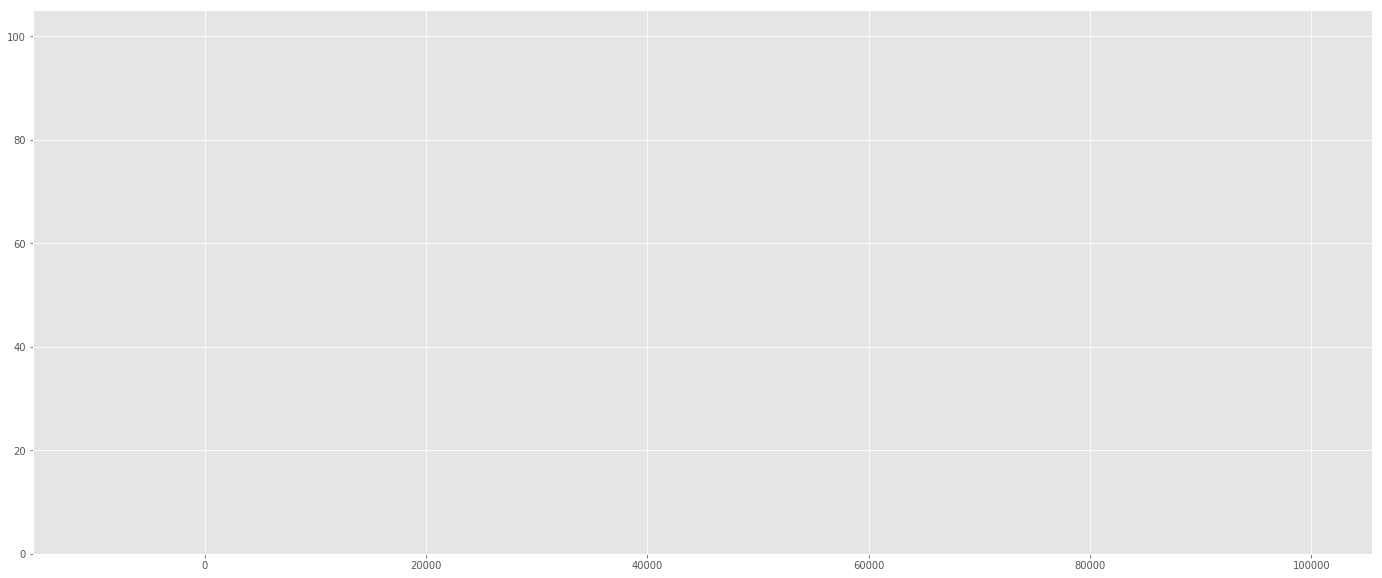

In [89]:
balance_percentage_plot = plt.bar(df_balance.binned_balance, df_balance.percentage)

In [92]:
df.sort_values(by = 'balance', ascending = False).head(10)

age           job   marital  education default  balance housing loan    contact  day month  duration  campaign  pdays  previous poutcome    y binned_age binned_balance
39989   51    management    single   tertiary      no   102127      no   no   cellular    3   jun        90         1     -1         0  unknown   no         50         100000
26227   59    management   married   tertiary      no    98417      no   no  telephone   20   nov       145         5     -1         0  unknown   no         50          95000
43393   84       retired   married  secondary      no    81204      no   no  telephone    1   apr       390         1     94         3  success  yes         80          80000
42558   84       retired   married  secondary      no    81204      no   no  telephone   28   dec       679         1    313         2    other  yes         80          80000
41693   60       retired   married    primary      no    71188      no   no   cellular    6   oct       205         1     -1         0  unknown   no         50          70000
19785   56    management  divorced   tertiary      no    66721      no   no   cellular    8   aug       442         2     -1         0  unknown   no         50          65000
21192   52   blue-collar   married    primary      no    66653      no   no   cellular   14   aug       109         3     -1         0  unknown   no         50          65000
19420   59        admin.   married    unknown      no    64343      no   no   cellular    6   aug        45         4     -1         0  unknown   no         50          60000
41374   32  entrepreneur    single   tertiary      no    59649      no   no   cellular    1   sep        69         2     -1         0  unknown   no         30          55000
12926   56   blue-collar   married  secondary      no    58932      no   no  telephone    7   jul       339         2     -1         0  unknown   no         50          55000

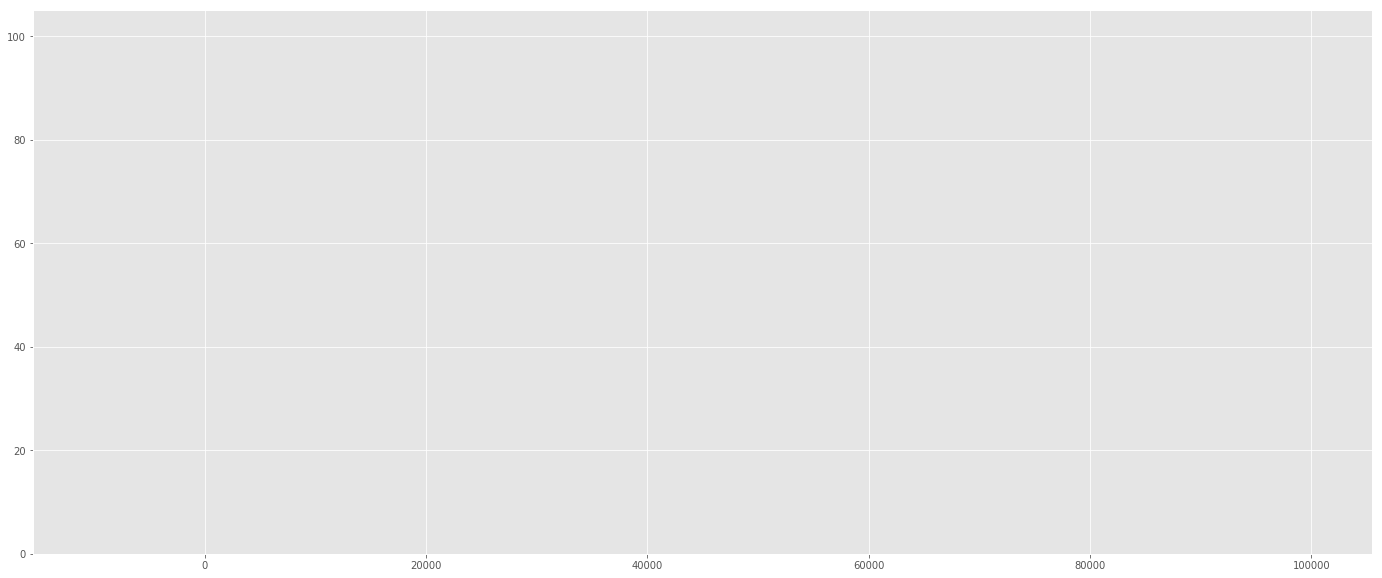

In [93]:
balance_percentage_plot = plt.bar(df_balance.binned_balance, df_balance.percentage, width=0.8, color = 'red')
sns.set_context({"figure.figsize": (24, 10)})

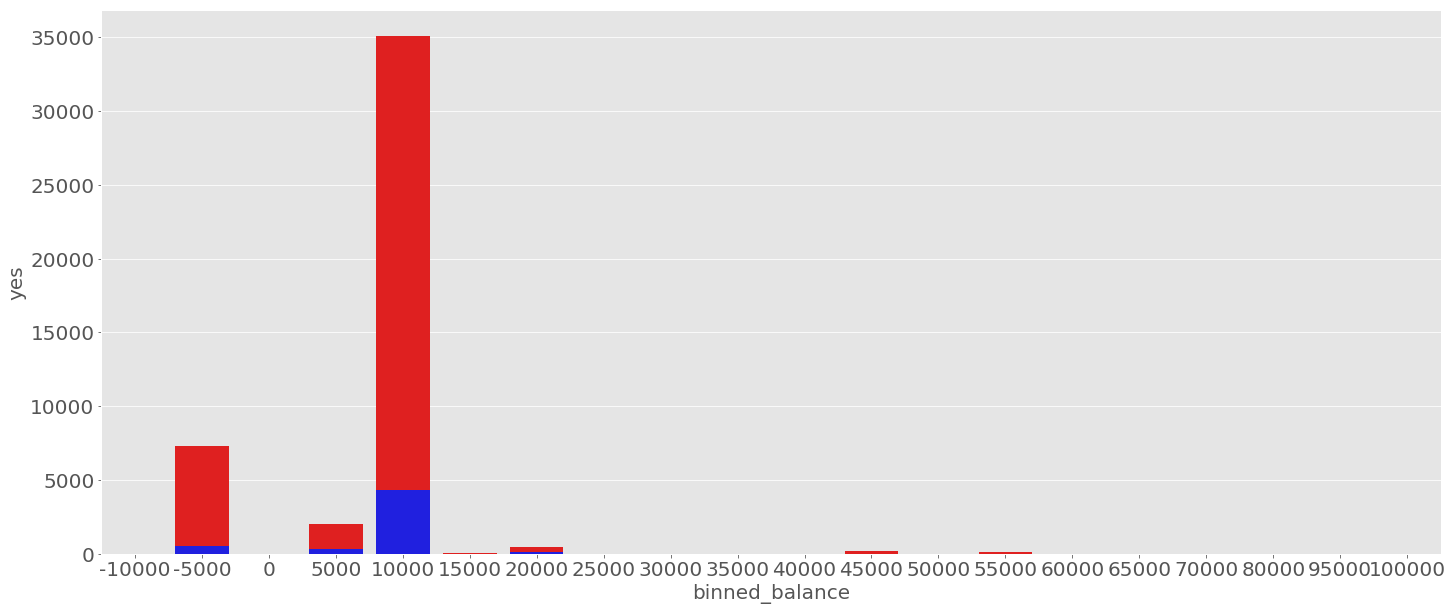

In [94]:
sns.set_context({"figure.figsize": (24, 10)})

sns.barplot(x = df_balance['binned_balance'], 
            y = df_balance.All, color = "red")

balance_plot = sns.barplot(x = df_balance['binned_balance'], 
            y = df_balance.yes, color = "blue")

for item in ([balance_plot.xaxis.label, balance_plot.yaxis.label] +
             balance_plot.get_xticklabels() + balance_plot.get_yticklabels()):
    item.set_fontsize(20)
#the yes rate vary quite a lot between different balance group

In [95]:
df.head(3)

age           job  marital  education default  balance housing loan  contact  day month  duration  campaign  pdays  previous poutcome   y binned_age binned_balance
0   58    management  married   tertiary      no     2143     yes   no  unknown    5   may       261         1     -1         0  unknown  no         50              0
1   44    technician   single  secondary      no       29     yes   no  unknown    5   may       151         1     -1         0  unknown  no         40              0
2   33  entrepreneur  married  secondary      no        2     yes  yes  unknown    5   may        76         1     -1         0  unknown  no         30              0

In [42]:
#investigate the percentage of yes in each housing catergory
df_housing = pd.crosstab(df.housing, df.y, margins=True)
df_housing.reset_index(inplace = True)
df_housing['percentage'] = df_housing.yes/df_housing.All*100
df_housing
#The yes rate is quite different between different housing group

y housing     no   yes    All  percentage
0      no  16727  3354  20081   16.702355
1     yes  23195  1935  25130    7.699960
2     All  39922  5289  45211   11.698480

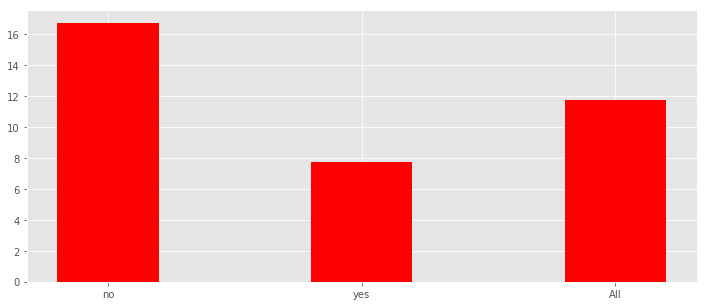

In [45]:
housing_percentage_plot = plt.bar(df_housing.housing, df_housing.percentage, width=0.4, color = 'red')
sns.set_context({"figure.figsize": (12, 5)})

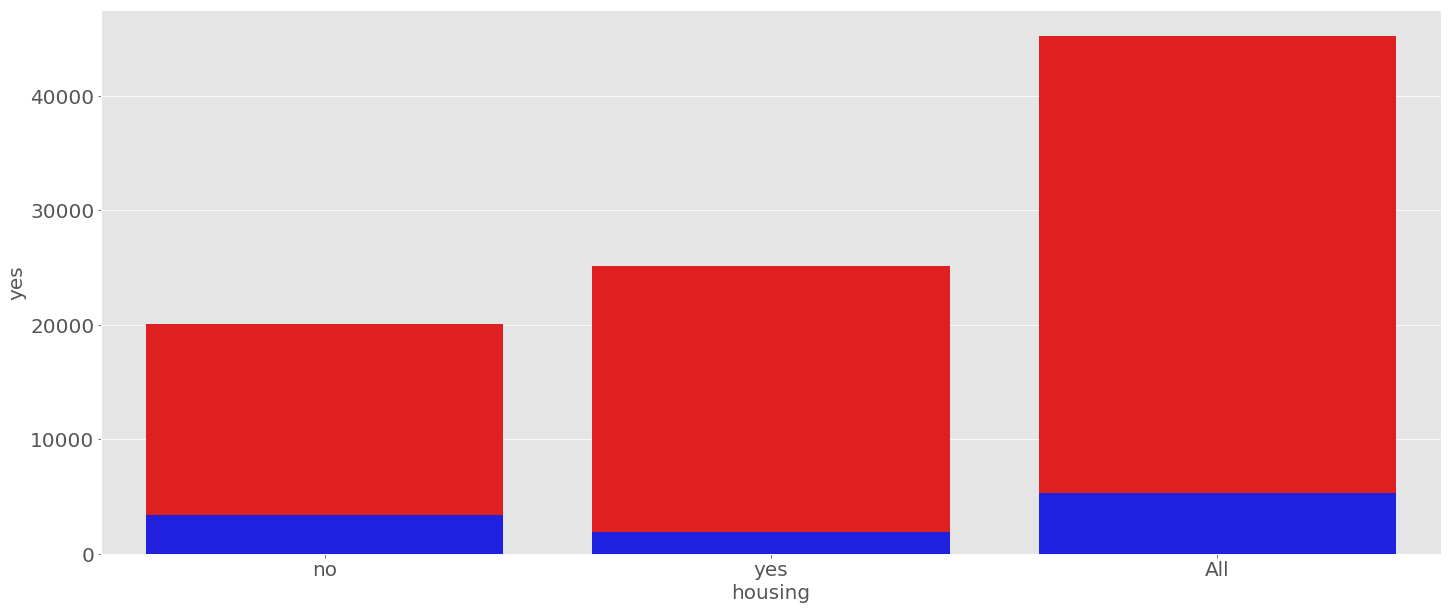

In [46]:
sns.set_context({"figure.figsize": (24, 10)})

sns.barplot(x = df_housing.housing, 
            y = df_housing.All, color = "red")

housing_plot = sns.barplot(x = df_housing.housing, 
            y = df_housing.yes, color = "blue")

for item in ([housing_plot.xaxis.label, housing_plot.yaxis.label] +
             housing_plot.get_xticklabels() + housing_plot.get_yticklabels()):
    item.set_fontsize(20)

Similar number from with and w/o houisng group, but percentage of subsribtion is very different. An important feature
to keep. 

In [47]:
#investigate the percentage of yes in each loan catergory
df_loan = pd.crosstab(df.loan, df.y, margins=True)
df_loan.reset_index(inplace = True)
df_loan['percentage'] = df_loan.yes/df_loan.All*100
df_loan
#The yes rate is quite different between different loan group, so loan is a good feature to keep

y loan     no   yes    All  percentage
0   no  33162  4805  37967   12.655727
1  yes   6760   484   7244    6.681391
2  All  39922  5289  45211   11.698480

In [48]:
#investigate the percentage of yes in each contact catergory
df_contact = pd.crosstab(df.contact, df.y, margins=True)
df_contact.reset_index(inplace = True)
df_contact['percentage'] = df_contact.yes/df_contact.All*100
df_contact
#The yes rate is quite different between different contact group, especially when contact is unknown it is 
#significantly lower than the other group

y    contact     no   yes    All  percentage
0   cellular  24916  4369  29285   14.918900
1  telephone   2516   390   2906   13.420509
2    unknown  12490   530  13020    4.070661
3        All  39922  5289  45211   11.698480

In [52]:
df.sort_values(by ='campaign', ascending  = False).head()

age          job  marital  education default  balance housing loan   contact  day month  duration  campaign  pdays  previous poutcome   y binned_age binned_balance binned_campaign
4330    45   management  married    unknown      no     9051     yes   no   unknown   19   may       124        63     -1         0  unknown  no         40           5000              60
11914   24   technician   single    primary      no      126     yes   no   unknown   20   jun        10        58     -1         0  unknown  no         20              0              55
5073    35   technician  married  secondary      no      432     yes   no   unknown   21   may      1094        55     -1         0  unknown  no         30              0              50
4299    30   management   single   tertiary      no      358     yes   no   unknown   19   may        88        51     -1         0  unknown  no         20              0              50
18713   35  blue-collar  married  secondary      no      280     yes  yes  cellular   31   jul        65        50     -1         0  unknown  no         30              0              45

In [49]:
df.campaign.describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [54]:
df.campaign.value_counts()


1     17544
2     12505
3      5521
4      3522
5      1764
6      1291
7       735
8       540
9       327
10      266
11      201
12      155
13      133
14       93
15       84
16       79
17       69
18       51
19       44
20       43
21       35
22       23
23       22
25       22
24       20
28       16
29       16
26       13
31       12
27       10
32        9
30        8
33        6
34        5
36        4
35        4
43        3
38        3
41        2
50        2
37        2
51        1
55        1
46        1
58        1
44        1
39        1
63        1
Name: campaign, dtype: int64

In [51]:
#The range is between 0 and 63
bins = np.arange(0,70,5)
labels = np.arange(0,70,5)[:len(bins)-1]
df['binned_campaign'] = pd.cut(df['campaign'], bins=bins, labels=labels)

df_campaign = pd.crosstab(df.binned_campaign, df.y, margins=True)
df_campaign.reset_index(inplace = True)
df_campaign['percentage'] = df_campaign.yes/df_campaign.All*100
df_campaign

df_campaign = df_campaign.iloc[:13,:]
df_campaign.sort_values(by ='binned_campaign', inplace = True)
df_campaign

#the yes rate vary quite different between different campaign group
# The previous campaign is a good feature to keep

y  binned_campaign     no   yes    All  percentage
0                0  35820  5036  40856   12.326219
1                5   2953   206   3159    6.521051
2               10    632    34    666    5.105105
3               15    277     9    286    3.146853
4               20    120     2    122    1.639344
9               25      3     0      3    0.000000
5               30     62     1     63    1.587302
11              35      1     0      1    0.000000
6               40     35     1     36    2.777778
10              45      2     0      2    0.000000
7               50     10     0     10    0.000000
12              55      1     0      1    0.000000
8               60      6     0      6    0.000000

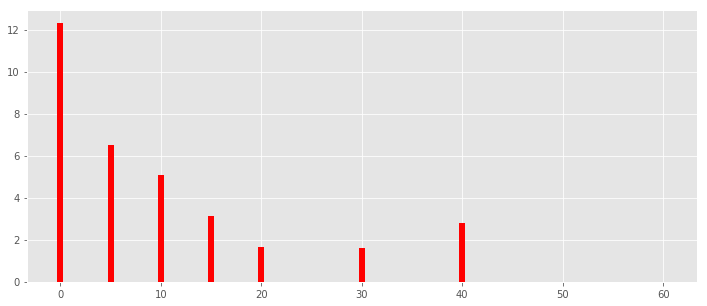

In [56]:
campaign_percentage_plot = plt.bar(df_campaign.binned_campaign, df_campaign.percentage, width=0.6, color = 'red')
sns.set_context({"figure.figsize": (12, 5)})

#not necessary the more the campaign the better...

In [103]:
df.previous.describe()

count    45211.000000
mean         0.580323
std          2.303441
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64

In [57]:
df.previous.value_counts()
#most people have been contacted 0 time before

0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
15        20
14        19
17        15
16        13
19        11
23         8
20         8
22         6
18         6
24         5
27         5
29         4
25         4
21         4
30         3
28         2
26         2
37         2
38         2
55         1
40         1
35         1
58         1
51         1
41         1
32         1
275        1
Name: previous, dtype: int64

In [58]:
#investigate the percentage of yes in each previous catergory
df_previous = pd.crosstab(df.previous, df.y, margins=True)
df_previous.reset_index(inplace = True)
df_previous['percentage'] = df_previous.yes/df_previous.All*100
df_previous


y  previous     no   yes    All  percentage
0         0  33570  3384  36954    9.157331
1         1   2189   583   2772   21.031746
2         2   1650   456   2106   21.652422
3         3    848   294   1142   25.744308
4         4    543   171    714   23.949580
5         5    338   121    459   26.361656
6         6    194    83    277   29.963899
7         7    151    54    205   26.341463
8         8     90    39    129   30.232558
9         9     68    24     92   26.086957
10       10     41    26     67   38.805970
11       11     50    15     65   23.076923
12       12     34    10     44   22.727273
13       13     29     9     38   23.684211
14       14     14     5     19   26.315789
15       15     19     1     20    5.000000
16       16     13     0     13    0.000000
17       17     12     3     15   20.000000
18       18      6     0      6    0.000000
19       19      9     2     11   18.181818
20       20      7     1      8   12.500000
21       21      3     1      4   25.000000
22       22      5     1      6   16.666667
23       23      7     1      8   12.500000
24       24      5     0      5    0.000000
25       25      4     0      4    0.000000
26       26      1     1      2   50.000000
27       27      5     0      5    0.000000
28       28      2     0      2    0.000000
29       29      3     1      4   25.000000
30       30      2     1      3   33.333333
31       32      1     0      1    0.000000
32       35      1     0      1    0.000000
33       37      2     0      2    0.000000
34       38      2     0      2    0.000000
35       40      1     0      1    0.000000
36       41      1     0      1    0.000000
37       51      1     0      1    0.000000
38       55      0     1      1  100.000000
39       58      0     1      1  100.000000
40      275      1     0      1    0.000000
41      All  39922  5289  45211   11.698480

In [71]:
#the 275 is an outlier, will create bins that not include this number
bins = np.arange(-5,65,5)
labels = np.arange(-5,65,5)[:len(bins)-1]
df['binned_previous'] = pd.cut(df['previous'], bins=bins, labels=labels)

df_previous = pd.crosstab(df.binned_previous, df.y, margins=True)
df_previous.reset_index(inplace = True)
df_previous['percentage'] = df_previous.yes/df_previous.All*100
df_previous

df_previous = df_previous.iloc[:12,:]
df_previous.sort_values(by ='binned_previous', inplace = True)
df_previous

#the yes rate vary quite different between different previous group
# The previous is a good feature to keep

y  binned_previous     no   yes      All  percentage
0               -5  33570  3384  36954.0    9.157331
1                0   5568  1625   7193.0   22.591408
4                5     47     6     53.0   11.320755
2               10    544   226    770.0   29.350649
3               15    146    40    186.0   21.505376
5               20     24     3     27.0   11.111111
6               25     13     3     16.0   18.750000
11              30      0     1      2.0   50.000000
7               35      2     0      2.0    0.000000
8               50      5     0      5.0    0.000000
10              55      1     1      1.0  100.000000
9              NaN      1     0      NaN         NaN

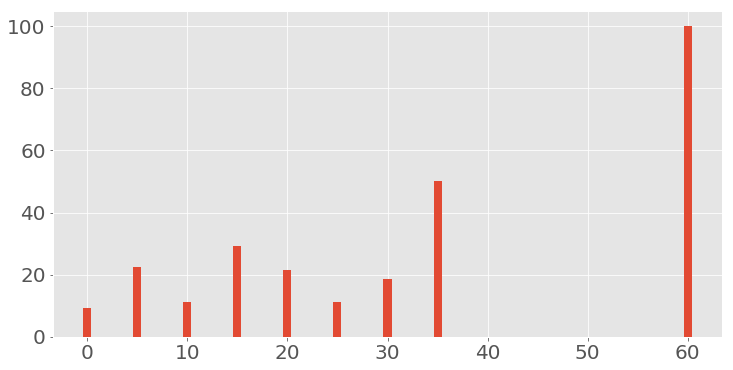

In [113]:
plt.figure(figsize = (12,6))

plt.bar(df_previous.binned_previous, df_previous.percentage)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('previous.svg', format= 'svg')

In [106]:
df.head(5)

age           job  marital  education default  balance housing loan  contact  day       ...       duration  campaign  pdays  previous  poutcome   y binned_age binned_balance binned_campaign binned_previous
0   58    management  married   tertiary      no     2143     yes   no  unknown    5       ...            261         1     -1         0   unknown  no         50              0               0               0
1   44    technician   single  secondary      no       29     yes   no  unknown    5       ...            151         1     -1         0   unknown  no         40              0               0               0
2   33  entrepreneur  married  secondary      no        2     yes  yes  unknown    5       ...             76         1     -1         0   unknown  no         30              0               0               0
3   47   blue-collar  married    unknown      no     1506     yes   no  unknown    5       ...             92         1     -1         0   unknown  no         40              0               0               0
4   33       unknown   single    unknown      no        1      no   no  unknown    5       ...            198         1     -1         0   unknown  no         30              0               0               0

[5 rows x 21 columns]

In [60]:
#investigate the percentage of yes in each poutcome catergory
df_poutcome = pd.crosstab(df.poutcome, df.y, margins=True)
df_poutcome.reset_index(inplace = True)
df_poutcome['percentage'] = df_poutcome.yes/df_poutcome.All*100
df_poutcome
#the sucess rate of poutcome has important indication for the sucess, however most people are in the unknown group

y poutcome     no   yes    All  percentage
0  failure   4283   618   4901   12.609671
1    other   1533   307   1840   16.684783
2  success    533   978   1511   64.725347
3  unknown  33573  3386  36959    9.161503
4      All  39922  5289  45211   11.698480

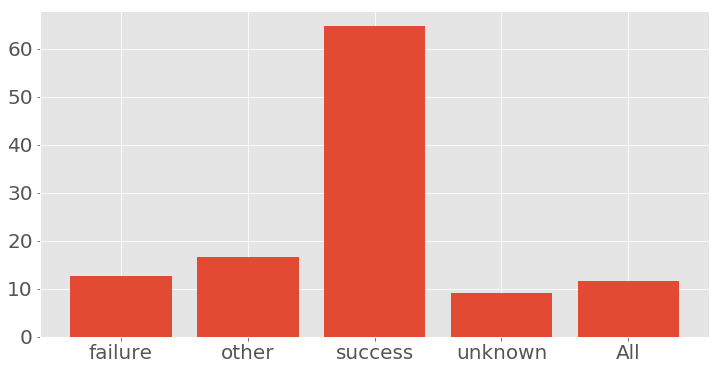

In [62]:
plt.figure(figsize = (12,6))

plt.bar(df_poutcome.poutcome, df_poutcome.percentage)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('previous.svg', format= 'svg')

Job, education, contanct and poutcome catergory have unknown values. In job and education, unknown does not 
affect many data, so clean it up. However, in contact and poutcome there are quite a lot a unknown, can not get rid of that.

Last contact day and month are not relavant to what we try to predict
Duration happens after the object pick up the phone, shouldn't include in features for prediction. Otherwise will
make the model leaky.
As discussed, pdays overlaps with previous contact.
In job catergory, admin is very similar to management, will combine.

In [64]:
#put marriage back
def DataCleanup(dataframe):
    df_1 = dataframe.copy()
    df_1 = df_1.drop(df_1[df_1['job'] == 'unknown'].index)
    df_1 = df_1.drop(df_1[df_1['education'] == 'unknown'].index)
    df_1.drop(['day', 'month','pdays','duration'],axis = 1,inplace = True)
    df_1['job'].replace('admin.','management', inplace = True)
    return df_1

In [65]:
df_raw  = pd.read_csv('bank_full_1.csv')

In [66]:
df_raw.shape

(45211, 17)

In [67]:
df_clean = DataCleanup(df_raw)

In [68]:
df_clean.shape

(43193, 13)

In [69]:
df_clean.head()

age           job  marital  education default  balance housing loan  contact  campaign  previous poutcome   y
0   58    management  married   tertiary      no     2143     yes   no  unknown         1         0  unknown  no
1   44    technician   single  secondary      no       29     yes   no  unknown         1         0  unknown  no
2   33  entrepreneur  married  secondary      no        2     yes  yes  unknown         1         0  unknown  no
5   35    management  married   tertiary      no      231     yes   no  unknown         1         0  unknown  no
6   28    management   single   tertiary      no      447     yes  yes  unknown         1         0  unknown  no

In [70]:
#check whether is any nan value in the numeric variable
df_clean.isnull().values.any()

False

In [73]:
#binned the numeric variable, use the bin that had been explored
def BinnedNumeric(dataframe):
    
    df = dataframe.copy()
    age_bin = np.arange(10,110,10)
    age_label = np.arange(10,110,10)[:len(age_bin)-1]
    df['binned_age'] = pd.cut(df['age'], bins=age_bin, labels=age_label)
    
    balance_bin = np.arange(-10000,150000,5000)
    balance_label = np.arange(-10000,150000,5000)[:len(balance_bin)-1]
    df['binned_balance'] = pd.cut(df['balance'], bins=balance_bin, labels=balance_label)
    
    campain_bin = np.arange(0,70,5)
    campain_label = np.arange(0,70,5)[:len(campain_bin)-1]
    df['binned_campaign'] = pd.cut(df['campaign'], bins=campain_bin, labels=campain_label)
    
    previous_bin = np.arange(-5,65,5)
    previous_label = np.arange(-5,65,5)[:len(previous_bin)-1]
    df['binned_previous'] = pd.cut(df['previous'], bins=previous_bin, labels=previous_label)
    
    df_1 = df.drop(['age','balance','campaign','previous'], axis = 1)
    return df_1

In [74]:
df_new_bin = BinnedNumeric(df_clean)

In [11]:
#df_binned = BinnedNumeric(df_clean)

In [75]:
df_new_bin.head()

job  marital  education default housing loan  contact poutcome   y binned_age binned_balance binned_campaign binned_previous
0    management  married   tertiary      no     yes   no  unknown  unknown  no         50              0               0              -5
1    technician   single  secondary      no     yes   no  unknown  unknown  no         40              0               0              -5
2  entrepreneur  married  secondary      no     yes  yes  unknown  unknown  no         30              0               0              -5
5    management  married   tertiary      no     yes   no  unknown  unknown  no         30              0               0              -5
6    management   single   tertiary      no     yes  yes  unknown  unknown  no         20              0               0              -5

In [76]:
def GetDummy(dataframe):
    df_dummy = dataframe.copy()
    for column in dataframe.columns:
        dummies = pd.get_dummies(df_dummy[column],drop_first=True).rename(columns=lambda x: column + '_' + str(x))
        df_dummy = pd.concat([df_dummy, dummies], axis=1)
        df_dummy.drop([column], inplace=True, axis=1)
    
    return df_dummy

In [77]:
df_new_bin_get_dummy = GetDummy(df_new_bin)

In [78]:
df_new_bin_get_dummy.shape

(43193, 84)

In [ ]:
df_new_bin_get_dummy.to_pickle('1026_data_for_modeling.csv')

Data is now ready for modeling after cleaning and basic binning. Below is some more data exploration with feature crossing. Some feature crossing help to improve the performace on training set, but not on the test set. It is unfortunate that some of the pattern is only in training set not in test set. 

In [79]:
df_binned_loan_balance = df_new_bin.copy()
df_binned_loan_balance['str_binned_balance'] = df_binned_loan_balance['binned_balance'].apply(lambda x: str(x))
df_binned_loan_balance['loan_balance'] =  df_binned_loan_balance[['loan','str_binned_balance']].apply(lambda x: ' '.join(x), axis=1)
df_binned_loan_balance.drop(['loan','binned_balance', 'str_binned_balance'],inplace = True, axis =1)
df_binned_loan_balance.head()


job  marital  education default housing  contact poutcome   y binned_age binned_campaign binned_previous loan_balance
0    management  married   tertiary      no     yes  unknown  unknown  no         50               0              -5         no 0
1    technician   single  secondary      no     yes  unknown  unknown  no         40               0              -5         no 0
2  entrepreneur  married  secondary      no     yes  unknown  unknown  no         30               0              -5        yes 0
5    management  married   tertiary      no     yes  unknown  unknown  no         30               0              -5         no 0
6    management   single   tertiary      no     yes  unknown  unknown  no         20               0              -5        yes 0

In [80]:
df_balance_loan = pd.crosstab(df_binned_loan_balance.loan_balance, df_binned_loan_balance.y, margins=True)
df_balance_loan.reset_index(inplace = True)
df_balance_loan['percentage'] = df_balance_loan.yes/df_balance_loan.All*100
df_balance_loan
#most people don't have loan and are in 0 balance bin. 
#crossing feature also get rid of some useless feature. For example some balance bin has no people, and by crossing it 
#with loan info it took care of it. 

y  loan_balance     no   yes    All  percentage
0      no -5000   4890   384   5274    7.281001
1          no 0  24567  3764  28331   13.285800
2      no 10000    348    83    431   19.257541
3     no 100000      1     0      1    0.000000
4      no 15000    125    13    138    9.420290
5      no 20000     78    11     89   12.359551
6      no 25000     34     8     42   19.047619
7      no 30000      7     3     10   30.000000
8      no 35000     12     1     13    7.692308
9      no 40000      7     0      7    0.000000
10     no 45000      2     0      2    0.000000
11      no 5000   1456   277   1733   15.983843
12     no 50000      2     2      4   50.000000
13     no 55000      5     0      5    0.000000
14     no 65000      2     0      2    0.000000
15     no 70000      1     0      1    0.000000
16     no 80000      0     2      2  100.000000
17     no 95000      1     0      1    0.000000
18   yes -10000      2     0      2    0.000000
19    yes -5000   1617   107   1724    6.206497
20        yes 0   4817   349   5166    6.755710
21    yes 10000     19     2     21    9.523810
22    yes 15000      9     0      9    0.000000
23    yes 20000      3     1      4   25.000000
24    yes 25000      3     0      3    0.000000
25    yes 30000      1     0      1    0.000000
26     yes 5000    162    14    176    7.954545
27    yes 50000      1     0      1    0.000000
28          All  38172  5021  43193   11.624569

In [81]:
df_binned_loan_poutcome = df_new_bin.copy()
df_binned_loan_poutcome['loan_outcome'] =  df_binned_loan_poutcome[['loan','poutcome']].apply(lambda x: ' '.join(x), axis=1)
df_binned_loan_poutcome.drop(['loan','poutcome'],inplace = True, axis =1)
df_binned_loan_poutcome.head()

job  marital  education default housing  contact   y binned_age binned_balance binned_campaign binned_previous loan_outcome
0    management  married   tertiary      no     yes  unknown  no         50              0               0              -5   no unknown
1    technician   single  secondary      no     yes  unknown  no         40              0               0              -5   no unknown
2  entrepreneur  married  secondary      no     yes  unknown  no         30              0               0              -5  yes unknown
5    management  married   tertiary      no     yes  unknown  no         30              0               0              -5   no unknown
6    management   single   tertiary      no     yes  unknown  no         20              0               0              -5  yes unknown

In [82]:
df_loan_poutcome = pd.crosstab(df_binned_loan_poutcome.loan_outcome, df_binned_loan_poutcome.y, margins=True)
df_loan_poutcome.reset_index(inplace = True)
df_loan_poutcome['percentage'] = df_loan_poutcome.yes/df_loan_poutcome.All*100
df_loan_poutcome

y loan_outcome     no   yes    All  percentage
0   no failure   3416   531   3947   13.453256
1     no other   1238   275   1513   18.175810
2   no success    471   875   1346   65.007429
3   no unknown  26413  2867  29280    9.791667
4  yes failure    706    56    762    7.349081
5    yes other    243    18    261    6.896552
6  yes success     36    42     78   53.846154
7  yes unknown   5649   357   6006    5.944056
8          All  38172  5021  43193   11.624569

In [83]:
df_binned_house_age = df_new_bin.copy()
df_binned_house_age['str_age'] = df_binned_house_age['binned_age'].apply(lambda x: str(x))
df_binned_house_age['age_house_combined'] =  df_binned_house_age[['str_age','housing']].apply(lambda x: ' '.join(x), axis=1)
df_binned_house_age.drop(['housing','binned_age','str_age'],inplace = True, axis =1)
df_binned_house_age.head()

job  marital  education default loan  contact poutcome   y binned_balance binned_campaign binned_previous age_house_combined
0    management  married   tertiary      no   no  unknown  unknown  no              0               0              -5             50 yes
1    technician   single  secondary      no   no  unknown  unknown  no              0               0              -5             40 yes
2  entrepreneur  married  secondary      no  yes  unknown  unknown  no              0               0              -5             30 yes
5    management  married   tertiary      no   no  unknown  unknown  no              0               0              -5             30 yes
6    management   single   tertiary      no  yes  unknown  unknown  no              0               0              -5             20 yes

In [84]:
df_house_age = pd.crosstab(df_binned_house_age.age_house_combined, df_binned_house_age.y, margins=True)
df_house_age.reset_index(inplace = True)
df_house_age['percentage'] = df_house_age.yes/df_house_age.All*100
df_house_age

y  age_house_combined     no   yes    All  percentage
0               10 no     37    17     54   31.481481
1              10 yes     10     2     12   16.666667
2               20 no   2067   700   2767   25.298157
3              20 yes   3574   372   3946    9.427268
4               30 no   5296   910   6206   14.663229
5              30 yes  10125   847  10972    7.719650
6               40 no   3999   540   4539   11.896894
7              40 yes   5691   416   6107    6.811855
8               50 no   3782   554   4336   12.776753
9              50 yes   2980   205   3185    6.436421
10              60 no    337   236    573   41.186736
11             60 yes     36    26     62   41.935484
12              70 no    187   151    338   44.674556
13             70 yes      2     6      8   75.000000
14              80 no     47    38     85   44.705882
15              90 no      2     1      3   33.333333
16                All  38172  5021  43193   11.624569

In [85]:
df_binned_housing_loan = df_new_bin.copy()
df_binned_housing_loan['housing_loan_combined'] = df_binned_housing_loan[['housing','loan']].apply(lambda x: ' '.join(x), axis=1)
df_binned_housing_loan.drop(['housing','loan'],inplace = True, axis =1)
df_binned_housing_loan.head()


job  marital  education default  contact poutcome   y binned_age binned_balance binned_campaign binned_previous housing_loan_combined
0    management  married   tertiary      no  unknown  unknown  no         50              0               0              -5                yes no
1    technician   single  secondary      no  unknown  unknown  no         40              0               0              -5                yes no
2  entrepreneur  married  secondary      no  unknown  unknown  no         30              0               0              -5               yes yes
5    management  married   tertiary      no  unknown  unknown  no         30              0               0              -5                yes no
6    management   single   tertiary      no  unknown  unknown  no         20              0               0              -5               yes yes

In [87]:
df_house_loan = pd.crosstab(df_binned_housing_loan.housing_loan_combined, df_binned_housing_loan.y, margins=True)
df_house_loan.reset_index(inplace = True)
df_house_loan['percentage'] = df_house_loan.yes/df_house_loan.All*100
df_house_loan

y housing_loan_combined     no   yes    All  percentage
0                 no no  13154  2931  16085   18.221946
1                no yes   2600   216   2816    7.670455
2                yes no  18384  1617  20001    8.084596
3               yes yes   4034   257   4291    5.989280
4                   All  38172  5021  43193   11.624569

The percentage of subscription with no personal nor housing loan is almost 3 times as the ones with both.

In [88]:
df_binned_cross_age_education = df_new_bin.copy()
df_binned_cross_age_education['str_age'] = df_binned_cross_age_education['binned_age'].apply(lambda x: str(x))
df_binned_cross_age_education['age_education_combined'] = df_binned_cross_age_education[['str_age','education']].apply(lambda x: ' '.join(x), axis=1)
df_binned_cross_age_education.drop(['education','binned_age','str_age'],inplace = True, axis =1)
df_binned_cross_age_education.head()

job  marital default housing loan  contact poutcome   y binned_balance binned_campaign binned_previous age_education_combined
0    management  married      no     yes   no  unknown  unknown  no              0               0              -5            50 tertiary
1    technician   single      no     yes   no  unknown  unknown  no              0               0              -5           40 secondary
2  entrepreneur  married      no     yes  yes  unknown  unknown  no              0               0              -5           30 secondary
5    management  married      no     yes   no  unknown  unknown  no              0               0              -5            30 tertiary
6    management   single      no     yes  yes  unknown  unknown  no              0               0              -5            20 tertiary

In [89]:
df_age_education = pd.crosstab(df_binned_cross_age_education.age_education_combined, df_binned_cross_age_education.y, margins=True)
df_age_education.reset_index(inplace = True)
df_age_education['percentage'] = df_age_education.yes/df_age_education.All*100
df_age_education

y  age_education_combined     no   yes    All  percentage
0              10 primary     12     6     18   33.333333
1            10 secondary     32    13     45   28.888889
2             10 tertiary      3     0      3    0.000000
3              20 primary    445    48    493    9.736308
4            20 secondary   3477   589   4066   14.485981
5             20 tertiary   1719   435   2154   20.194986
6              30 primary   1741   109   1850    5.891892
7            30 secondary   8470   803   9273    8.659549
8             30 tertiary   5210   845   6055   13.955409
9              40 primary   1999   132   2131    6.194275
10           40 secondary   5219   478   5697    8.390381
11            40 tertiary   2472   346   2818   12.278211
12             50 primary   1771   134   1905    7.034121
13           50 secondary   3269   380   3649   10.413812
14            50 tertiary   1722   245   1967   12.455516
15             60 primary    127    59    186   31.720430
16           60 secondary    150   119    269   44.237918
17            60 tertiary     96    84    180   46.666667
18             70 primary     86    72    158   45.569620
19           70 secondary     63    51    114   44.736842
20            70 tertiary     40    34     74   45.945946
21             80 primary     31    27     58   46.551724
22           80 secondary      8     8     16   50.000000
23            80 tertiary      8     3     11   27.272727
24             90 primary      0     1      1  100.000000
25           90 secondary      2     0      2    0.000000
26                    All  38172  5021  43193   11.624569

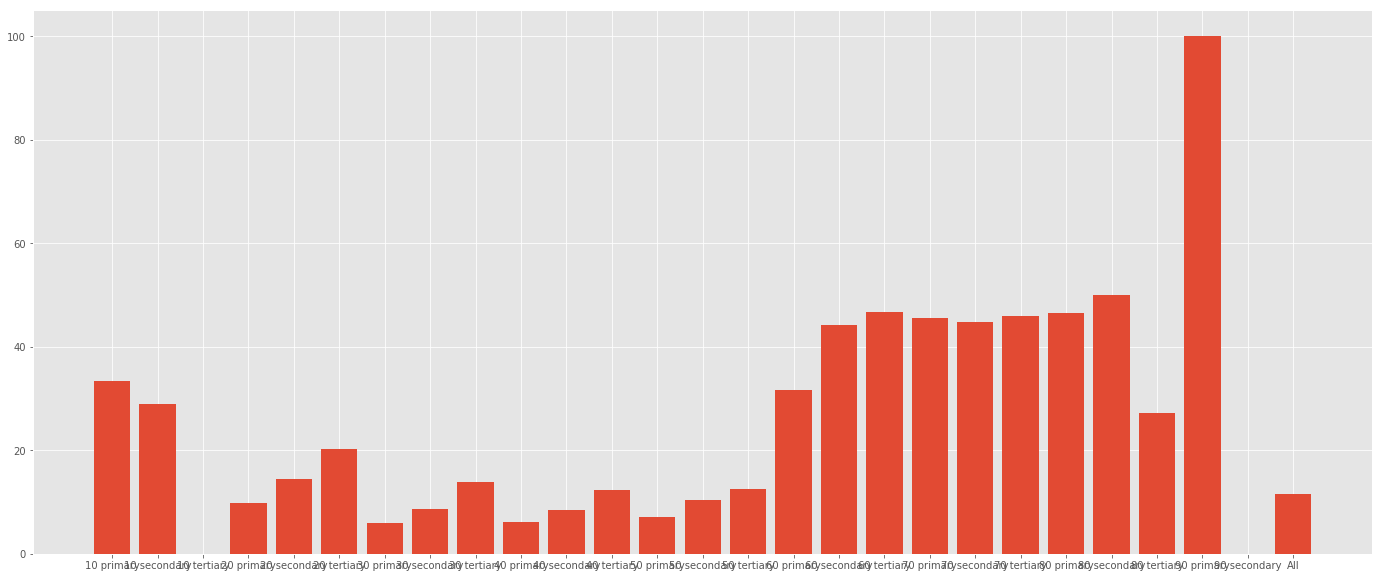

In [90]:
sns.set_context({"figure.figsize": (24, 10)})

education_age_percentage_plot = plt.bar(df_age_education.age_education_combined, df_age_education.percentage)


Create a bunch of dataframe that contain crossing features.

In [92]:
df_binned_loan_balance_dummy = GetDummy(df_binned_loan_balance)

In [79]:
df_binned_loan_balance_dummy.to_pickle('loan_balance.pkl')

In [93]:
df_loan_poutcome = GetDummy(df_binned_loan_poutcome)

In [64]:
df_loan_poutcome.to_pickle('loan_poutcome.pkl')

In [94]:
df_house_age_dummy = GetDummy(df_binned_house_age)

In [58]:
df_house_age_dummy.to_pickle('combine_age_housing.pkl')

In [95]:
df_dummy_age_education_combine = GetDummy(df_binned_cross_age_education)

In [46]:
df_dummy_age_education_combine.to_pickle('combine_age_education.pkl')

In [96]:
df_get_dummy_housing_loan = GetDummy(df_binned_housing_loan)

In [51]:
df_get_dummy_housing_loan.to_pickle('df_housing_loan.pkl')